In [21]:
%load_ext autoreload
%autoreload 2
#  base environment
from notebook_setup import *

import os
import dotenv
import numpy as np
import functools

# noise generation
from noise import pnoise2, pnoise3
from joblib import Parallel, delayed

# visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings

# load environment variables
_ = dotenv.load_dotenv(override=True)

from training.networks.neuraloperator.multipole import MultiPoleScoreNet
from data.synthetic.low_frequency import PinkNoise1D
from training.noising_kernels import RBFIrregular
from training.collate import CollateMesh, CompositeCollate, MakeConditional
from training.networks.neuraloperator.multipole import MultiPoleScoreNet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing Denoising Operators

Here, we test the components that build up our denoising diffusion operator. In particular, we test the following components:

1. The noising Kernel that comes from a Gaussian random field.
2. A denoising neural operator that is trained to revert the noising kernel for a specific variance.


## A 1D Example

Here, we will start off by testing the noising kernel. We have a dateset with low-frequency functions inside it.


**A Low Frequency Dataset**: Here, we sample from a pink noise that is passed thorugh a low-pass filter to model structured data.


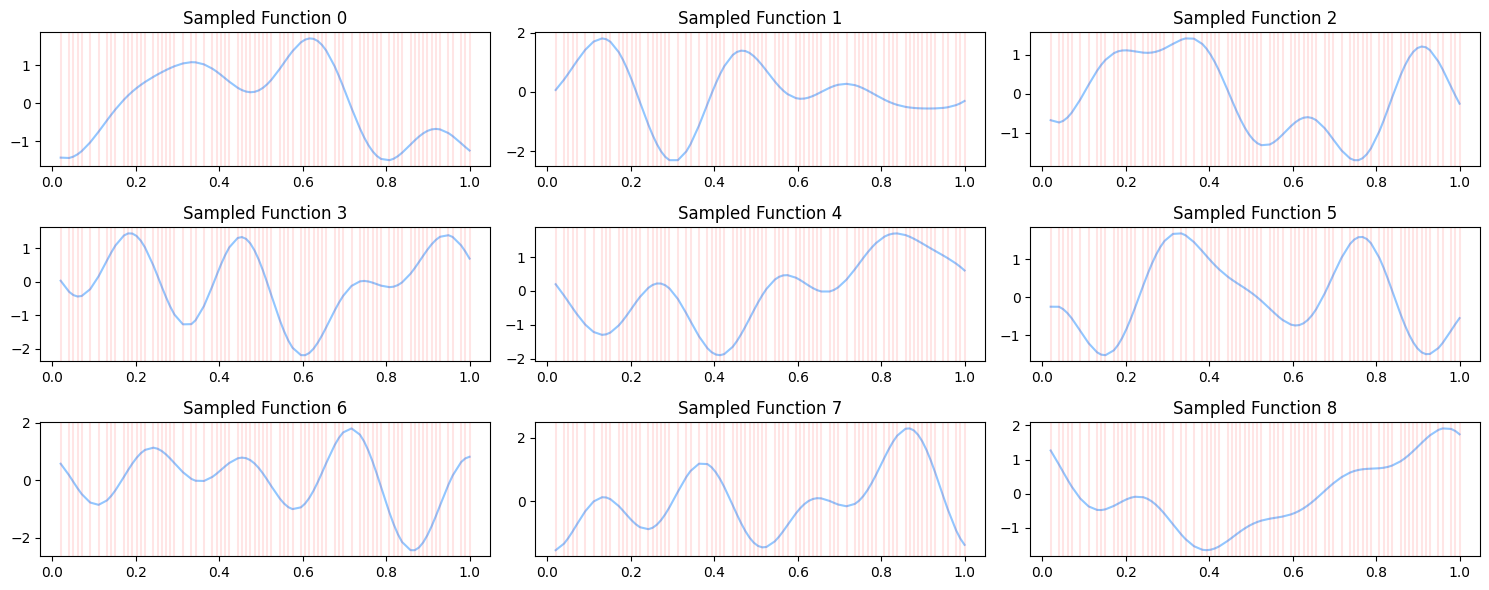

In [2]:
dset = PinkNoise1D(
    total_count=1000,
    num_samples=100,
    low_pass_threshold=0.05,
    make_irregular=True,
    bernoulli_p=0.8,
    fixed_irregularity_seed=42,
)
# plot 9 first samples of the dataset
fig, axes = plt.subplots(3, 3, figsize=(15, 6))
for i in range(9):
    ax = axes[i // 3, i % 3]
    coords, intensities = dset[i]
    ax.plot(coords.squeeze(), intensities.squeeze())
    ax.set_title(f"Sampled Function {i}")
    # add small vertical lines on each coords 
    for x in coords.squeeze():
        ax.axvline(x, color="red", alpha=0.1)
plt.tight_layout()

**Testing the Noising Kernel**: Now, we will test the noising (RBF) kernel that is being used in the codebase. This will gradually turn the random process into a Gaussian process.


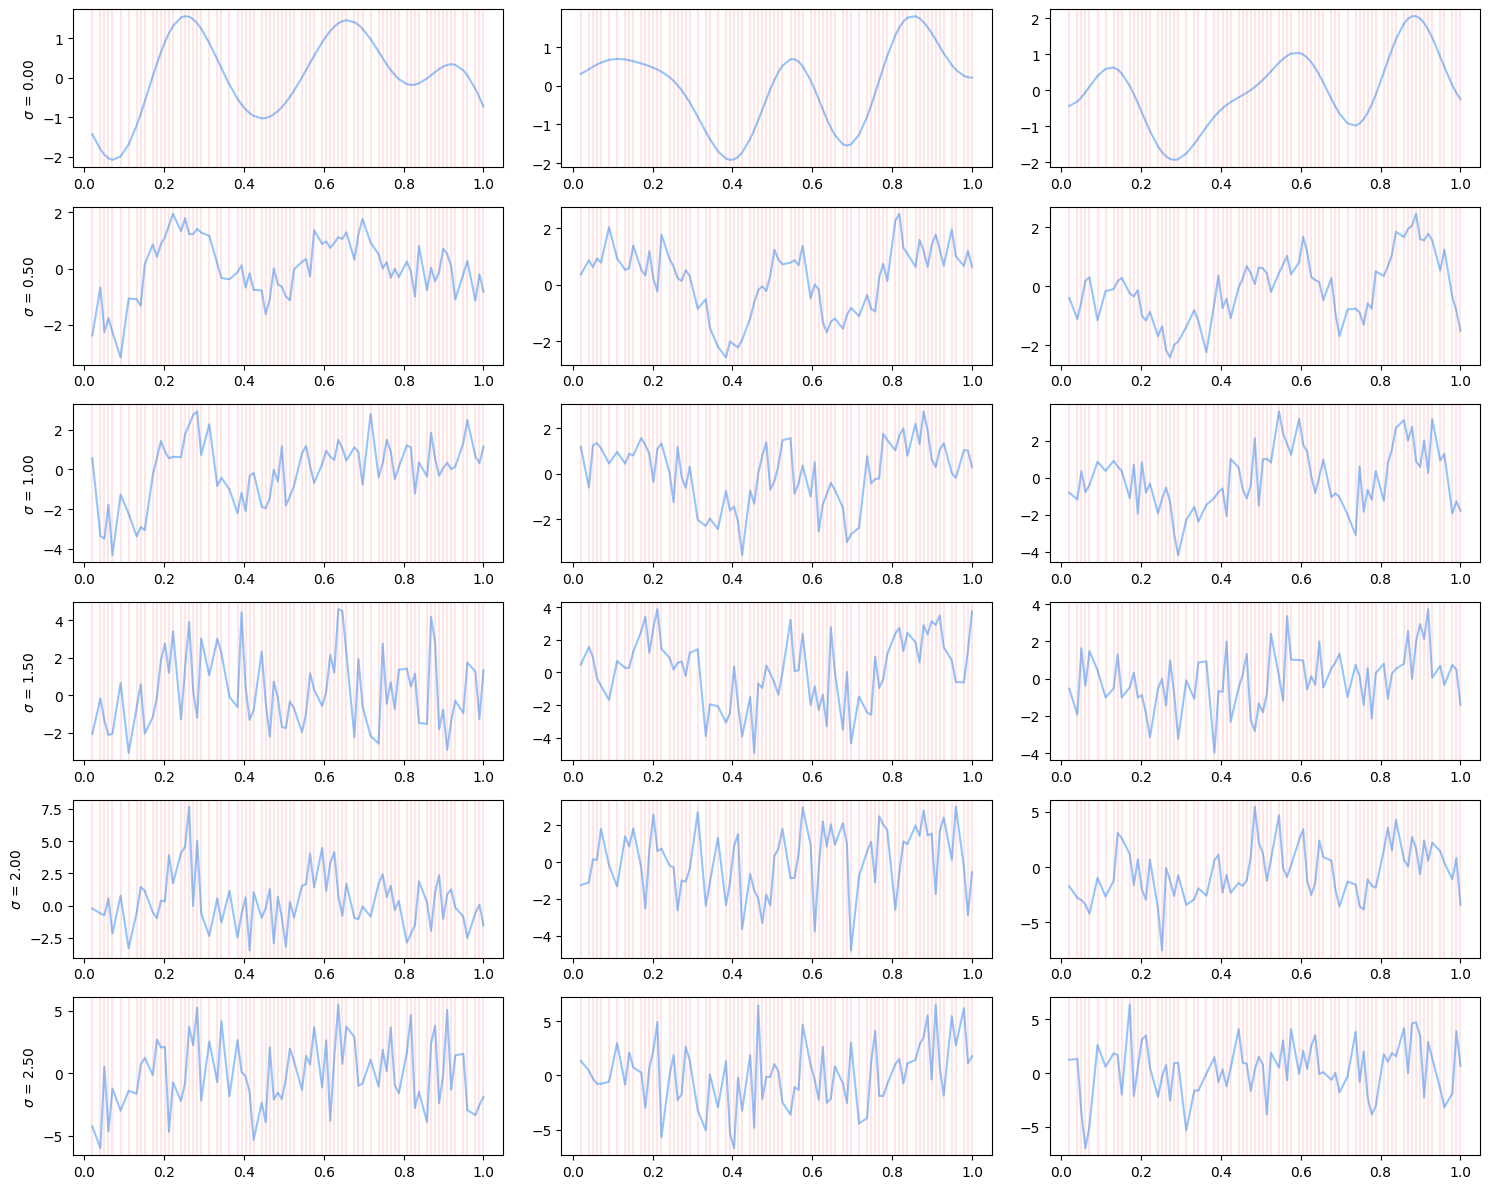

In [3]:
batch_size = 3
P_mean = -1.2 
P_std = 1.2
sigma_data = 0.5
steps = 6
torch.random.manual_seed(42)
#### 

dloader = DataLoader(dset, batch_size=batch_size, collate_fn=CompositeCollate([MakeConditional(), CollateMesh()]))
noising_kernel = RBFIrregular()
iterator = iter(dloader)
(coords, intensities), conditioning = next(iterator)

fig, axes = plt.subplots(steps, batch_size, figsize=(15, 2 * (steps)))
rnd_normal = torch.randn(batch_size).to(dtype=intensities.dtype).to(device=intensities.device)
sorted_sigma = rnd_normal.sort().values

for noise_scheduler, sigma_val in enumerate([0.0, 0.5, 1.0, 1.5, 2.0, 2.5]):
    sigma = torch.tensor(sigma_val).float().to(device=intensities.device).repeat(batch_size)  
    noised_out = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(batch_size, 1, 1))
    
    for i in range(batch_size):
        ax = axes[noise_scheduler, i]
        ax.plot(coords.squeeze(), noised_out[i].squeeze())
        if i == 0:
            # set x - axis label
            ax.set_ylabel(f"$\\sigma$ = {sigma[i].item():.2f}")
        
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)

plt.tight_layout()

## Training a Single Step Denoiser

Now let us train a single step denoiser that will revert a step in the noising kernel. To do that, we would first create a dataset by sampling from the base process, applying a noising kernel on it, and then training a neural network to revert the noising kernel.


In [76]:
noising_sigma = 1.5
num_epochs = 10
####

denoiser_network = MultiPoleScoreNet(
    coord_dim=1,
    num_channels=1,
    latent_channels=8,
    radius=0.01,
    radii_mult=[2, 4, 8],
    iter_count=3,
)
optim = torch.optim.Adam(denoiser_network.parameters(), lr=1e-3)
####


# TODO: fix Suppress all warnings
warnings.filterwarnings("ignore")
all_loss_history = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for (coords, intensities), conditioning in dloader:
        # zero grad
        optim.zero_grad()

        # sample noise
        sigma = torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size)
        noisy = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(batch_size, 1, 1))

        # train the model
        denoised = denoiser_network(coords, noisy.unsqueeze(-1), conditioning)
        denoised = denoised.squeeze(-1)
        # compute loss
        loss = torch.nn.functional.mse_loss(denoised, intensities)
        all_loss_history.append(loss.item())

        # backprop
        loss.backward()
        optim.step()
        pbar.set_description(f"Loss: {loss.item():.3f}")


Loss: 0.316: 100%|██████████| 10/10 [02:08<00:00, 12.82s/it]


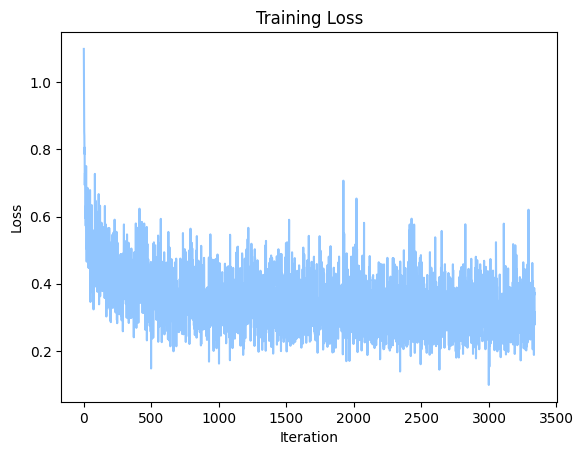

In [77]:
plt.plot(all_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


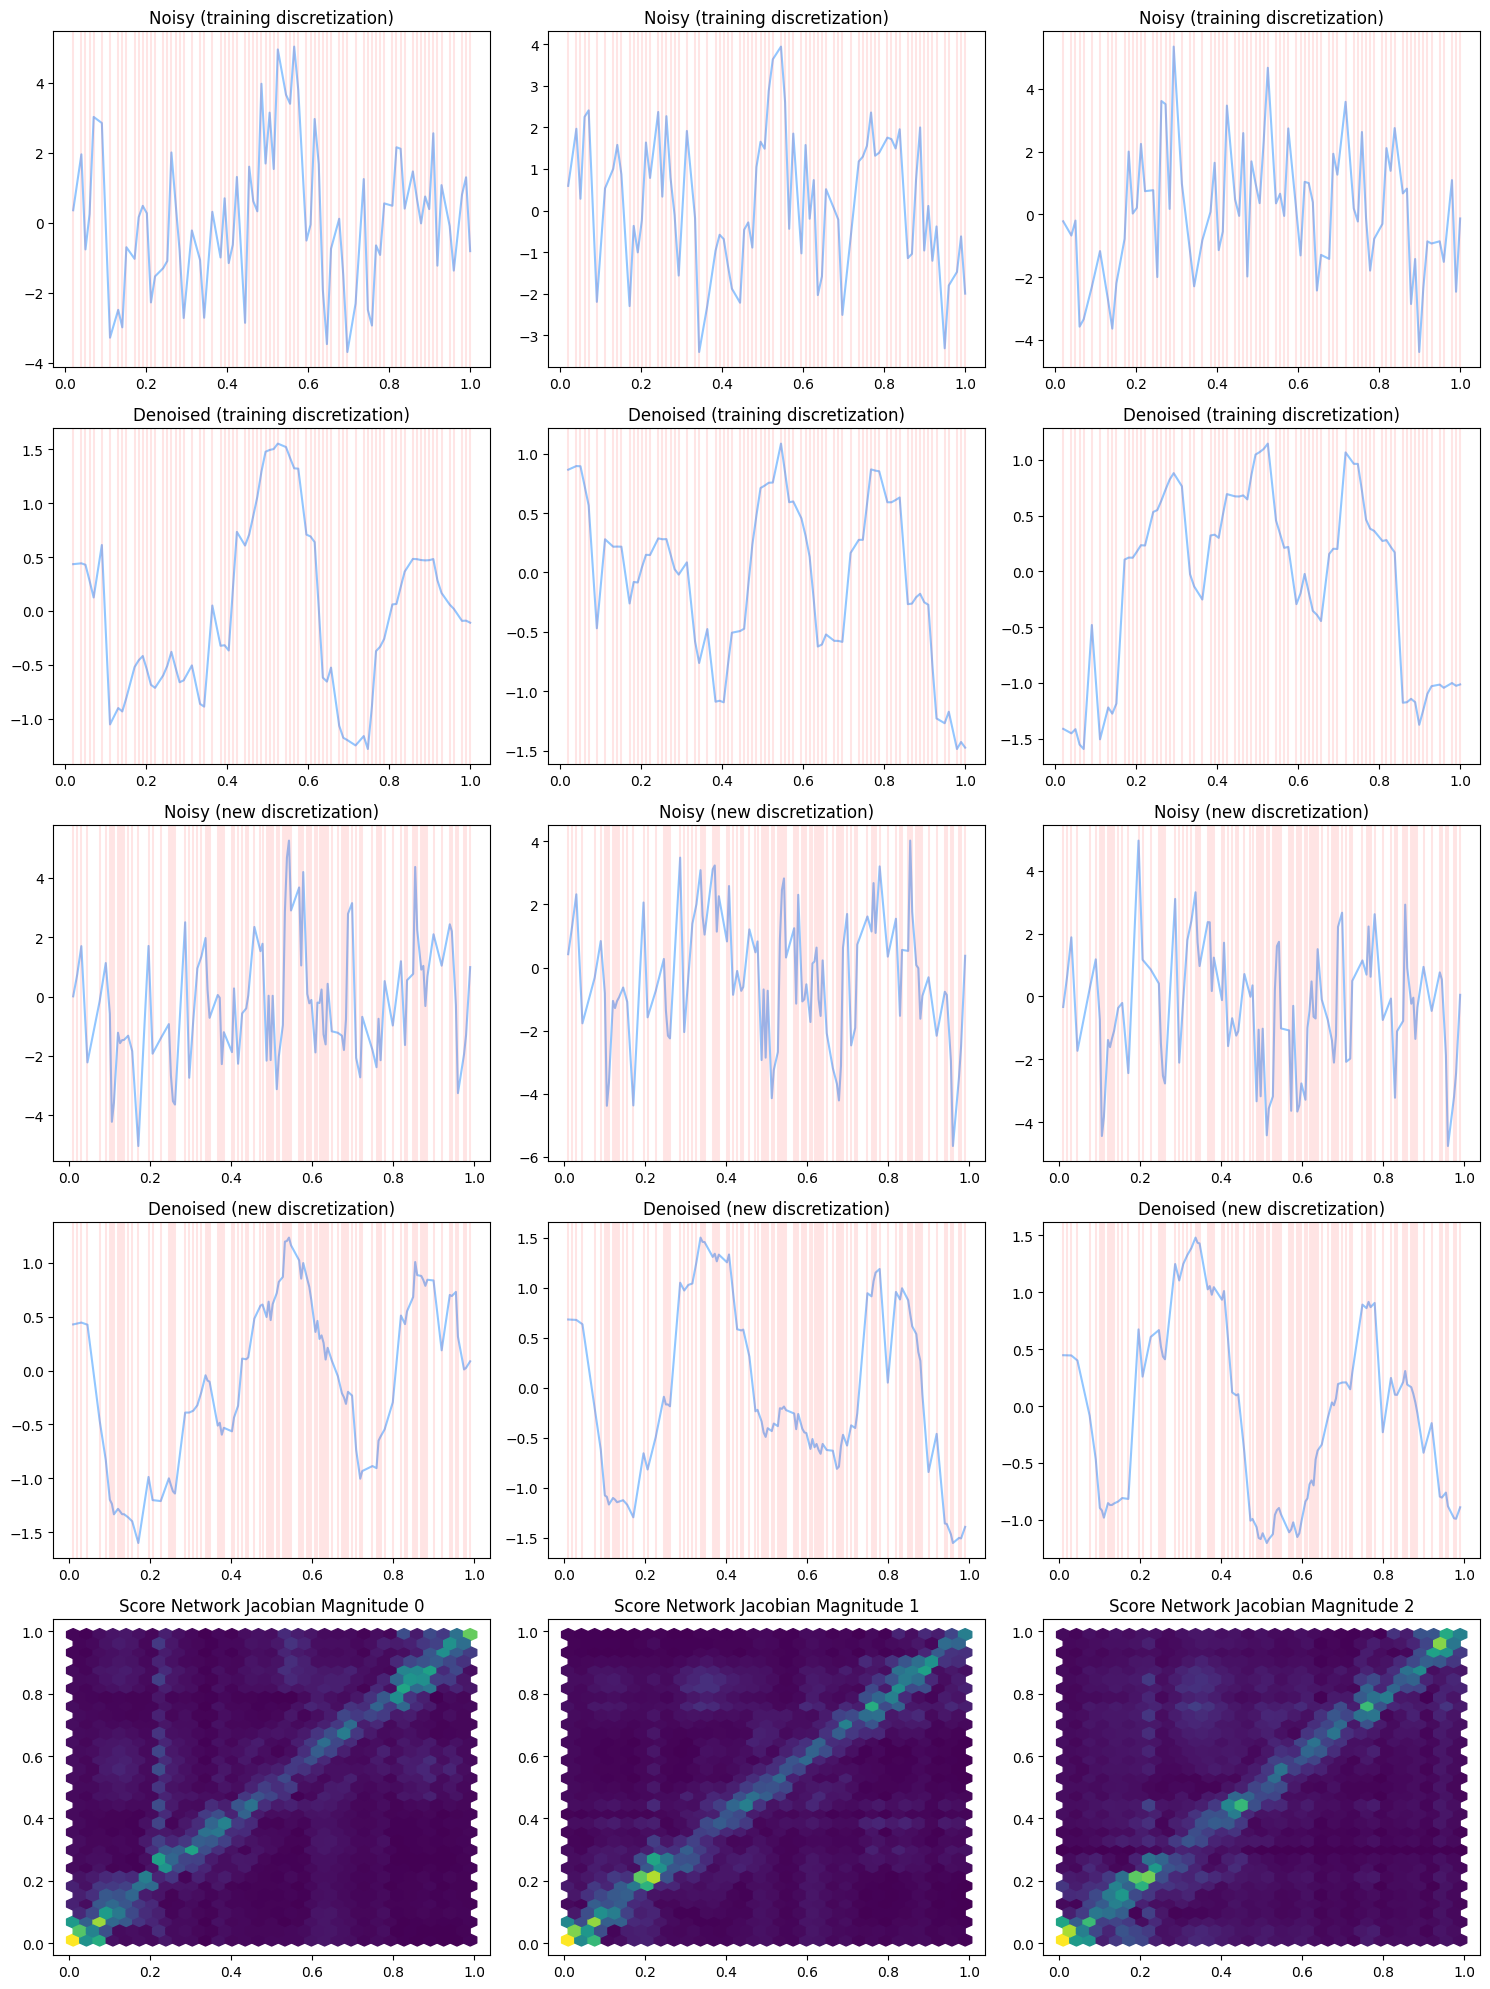

In [80]:
fig, axes = plt.subplots(5, 3, figsize=(15, 5 * 4))

(coords, intensities), conditioning = next(iter(dloader))

sigma = torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size)
noisy = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(batch_size, 1, 1))

# try to denoise the noisy data from the training set
with torch.no_grad():
    denoised = denoiser_network(coords, noisy.unsqueeze(-1), conditioning).squeeze(-1)
    for i in range(batch_size):
        ax = axes[0, i]
        ax.plot(coords.squeeze(), noisy[i].squeeze())
        ax.set_title("Noisy (training discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)
        ax = axes[1, i]
        ax.plot(coords.squeeze(), denoised[i].squeeze())
        ax.set_title("Denoised (training discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)

# sample data with totally different discretizations
ood_dset = PinkNoise1D(
    total_count=3,
    num_samples=200,
    low_pass_threshold=0.05,
    make_irregular=True,
    bernoulli_p=0.5,
    fixed_irregularity_seed=42,
)
ood_dloader = DataLoader(ood_dset, batch_size=3, collate_fn=CompositeCollate([MakeConditional(), CollateMesh()]))
(coords, intensities), conditioning = next(iter(ood_dloader))

sigma = torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(1)
noisy = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(1, 1, 1))
denoised = denoiser_network(coords, noisy.unsqueeze(-1), conditioning).squeeze(-1)

with torch.no_grad():
    for i in range(batch_size):
        ax = axes[2, i]
        ax.plot(coords.squeeze(), noisy[i].squeeze())
        ax.set_title("Noisy (new discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)
        ax = axes[3, i]
        ax.plot(coords.squeeze(), denoised[i].squeeze())
        ax.set_title("Denoised (new discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)

# fine the Jacobian of denoised wrt noisy using torch.func.jacfwd
J = torch.autograd.functional.jacobian(
    functools.partial(
        denoiser_network,
        conditioning=conditioning,
        sigma=None,
        conditioning_augmented=None,
    ), 
    inputs=(coords, noisy.unsqueeze(-1),),
    create_graph=True,
)
jacs = []
for i in range(batch_size):
    jacs.append(J[1][i, :, :, i, :, :].detach().squeeze().cpu())

meshgird = np.meshgrid(*[coords.squeeze().cpu().numpy() for _ in range(2)])
for i in range(batch_size):
    ax = axes[4, i]
    ax.set_title(f"Score Network Jacobian Magnitude {i}")
    ax.hexbin(
        x=meshgird[0].flatten(),
        y=meshgird[1].flatten(),
        C=jacs[i].abs().flatten(),
        gridsize=30,
    )


plt.tight_layout()